In [ ]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# download dataset from kaggle
# ! pip install -q kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle competitions download -c new-york-city-taxi-fare-prediction

In [ ]:
# unzip the data
# !unzip "/content/new-york-city-taxi-fare-prediction.zip" -d "/content/drive/MyDrive/15-07-2022"

In [ ]:
# install the pyspark
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 36 kB/s 
     |████████████████████████████████| 199 kB 61.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=0715961355c15f357f0936a53b9cfd8e32337f2c7cee3933e4fe8d3b76974d3e
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upg

In [ ]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pyspark
import pyspark.sql.functions as F
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.sql import functions as f, udf
from pyspark.sql.window import Window
from pyspark.sql.functions import col
from pyspark.sql.functions import col,isnan, when, count
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.regression import DecisionTreeRegressor

In [ ]:
# create the session
conf = pyspark.SparkConf()
# create the context
sc = pyspark.SparkContext.getOrCreate(conf=conf)
sqlcontext = SQLContext(sc)
spark = SparkSession.builder.getOrCreate()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [ ]:
# read the data and display
data = spark.read.csv('/content/drive/MyDrive/15-07-2022/train.csv',header='true')
data.show(5)

+--------------------+-----------+--------------------+----------------+---------------+-----------------+----------------+---------------+
|                 key|fare_amount|     pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+--------------------+-----------+--------------------+----------------+---------------+-----------------+----------------+---------------+
|2009-06-15 17:26:...|        4.5|2009-06-15 17:26:...|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|
|2010-01-05 16:52:...|       16.9|2010-01-05 16:52:...|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|
|2011-08-18 00:35:...|        5.7|2011-08-18 00:35:...|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|
|2012-04-21 04:30:...|        7.7|2012-04-21 04:30:...|       -73.98713|      40.733143|       -73.991567|       40.758092|              1|
|2010-03-09 07:51:..

In [ ]:
# total number of rows
data.count()

55423856

In [ ]:
# columns and their datatype
data.printSchema()

root
 |-- key: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- passenger_count: string (nullable = true)



In [ ]:
# type casting the data
# the data of these columns should be in double or integer to do the analysis
# the date columns are not converted as they already in string and the default data type of date is string
data=data.withColumn("fare_amount",data.fare_amount.cast('double'))
data=data.withColumn("pickup_longitude",data.pickup_longitude.cast('double'))
data=data.withColumn("pickup_latitude",data.pickup_latitude.cast('double'))
data=data.withColumn("dropoff_longitude",data.dropoff_longitude.cast('double'))
data=data.withColumn("dropoff_latitude",data.dropoff_latitude.cast('double'))
data=data.withColumn("passenger_count",data.passenger_count.cast('integer'))

In [ ]:
# columns and their datatype
data.printSchema()

root
 |-- key: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)



In [ ]:
# looking for statistical properties of dataset
data.describe().show()

+-------+--------------------+------------------+--------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|                 key|       fare_amount|     pickup_datetime|  pickup_longitude|  pickup_latitude| dropoff_longitude|  dropoff_latitude|   passenger_count|
+-------+--------------------+------------------+--------------------+------------------+-----------------+------------------+------------------+------------------+
|  count|            55423856|          55423856|            55423856|          55423856|         55423856|          55423480|          55423480|          55423856|
|   mean|                null|11.345045601663852|                null|-72.50968444358729| 39.9197917868882|-72.51120972971809|39.920681444828844|1.6853799201556816|
| stddev|                null|  20.7108321982325|                null| 12.84888338140265|9.642353041994934|12.782196517830771| 9.633345796415124|1.3276643570959683|
|    min|2

In [ ]:
# select the fare amount column to look for statiscal properties
data.select("fare_amount").describe().show()

+-------+------------------+
|summary|       fare_amount|
+-------+------------------+
|  count|          55423856|
|   mean|11.345045601663852|
| stddev|  20.7108321982325|
|    min|             -0.01|
|    max|            999.99|
+-------+------------------+



In [ ]:
# as most of the data is around 20 se we remove the values less than 0 and greater than 100
# in order to get rid of outliers
data = data.filter((data.fare_amount  > 0)&(data.fare_amount  < 100))

In [ ]:
# select the fare amount column to look for statiscal properties
data.select("fare_amount").describe().show()

+-------+------------------+
|summary|       fare_amount|
+-------+------------------+
|  count|          55397123|
|   mean|11.289828684606057|
| stddev| 9.395304238344748|
|    min|              0.01|
|    max|             99.99|
+-------+------------------+



In [ ]:
# total number of rows
data.count()

55397123

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


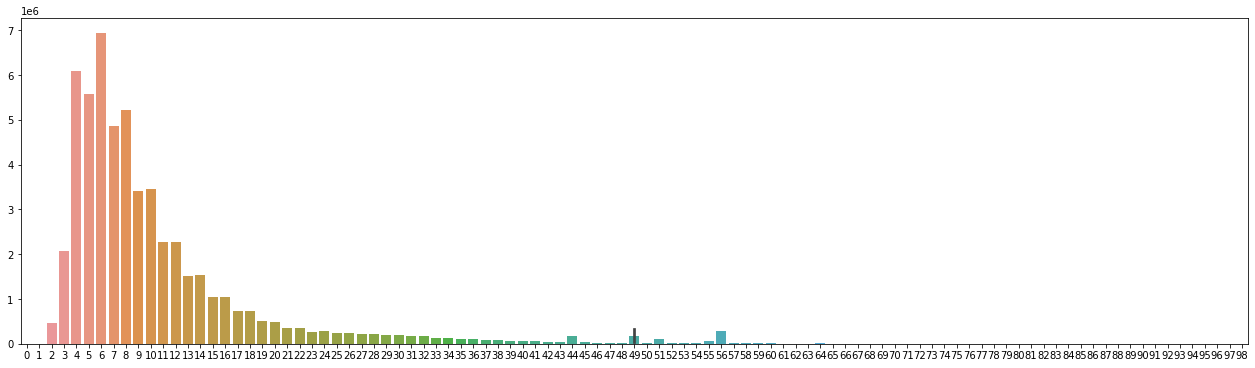

In [ ]:
# Fare amount distribution
hist = data.select('fare_amount').rdd.flatMap(lambda x: x).histogram(100)
plt.figure(figsize=(22,6))
sns.barplot(list(map(lambda x: int(x), hist[0][:-1])), hist[1])

In [ ]:
# take only values for passeneger greaterr than 0
data = data.filter(data['passenger_count']>0)

In [ ]:
# check for null values
data.select([F.count(F.when(F.isnan(c),c)).alias(c) for c in data.columns]).show()

+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|key|fare_amount|pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|  0|          0|              0|               0|              0|                0|               0|              0|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+



In [ ]:
# calculate distance of trip using longitude and latitude value
p = 0.017453292519943295
data = data.withColumn('distance', 0.6213712*12742*F.asin((0.5-F.cos((data['dropoff_latitude']-data['pickup_latitude'])*p)/2 +
                                      F.cos(data['pickup_latitude']*p) * F.cos(data['dropoff_latitude']*p) *
                                     (1-F.cos((data['dropoff_longitude']-data['pickup_longitude'])*p))/2)**0.5))

In [ ]:
# display the data
data.show(5)

+--------------------+-----------+--------------------+----------------+---------------+-----------------+----------------+---------------+------------------+
|                 key|fare_amount|     pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|          distance|
+--------------------+-----------+--------------------+----------------+---------------+-----------------+----------------+---------------+------------------+
|2009-06-15 17:26:...|        4.5|2009-06-15 17:26:...|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|0.6404870231407276|
|2010-01-05 16:52:...|       16.9|2010-01-05 16:52:...|      -74.016048|      40.711303|       -73.979268|       40.782004|              1| 5.250669652366417|
|2011-08-18 00:35:...|        5.7|2011-08-18 00:35:...|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|0.8634109565058572|
|2012-04-21 04:30:...|        7.7|2012-04-21 0

In [ ]:
# select the fare amount column to look for statiscal properties
data.select("distance").describe().show()

+-------+------------------+
|summary|          distance|
+-------+------------------+
|  count|          55396747|
|   mean|  12.2688909857812|
| stddev|229.85650118535455|
|    min|               0.0|
|    max| 12234.05363206257|
+-------+------------------+



In [ ]:
# we remove the values less than 0 and greater than 150
# in order to get rid of outliers
data = data.filter((data.distance  > 0)&(data.distance  < 150))

In [ ]:
# total number of rows
data.count()

53706168

In [ ]:
# direction of a trip from 180 to -180 degrees
data = data.withColumn('d_lon', data['pickup_longitude'] - data['dropoff_longitude'] )
data = data.withColumn('d_lat', data['pickup_latitude'] - data['dropoff_latitude'])
data = data.withColumn('lon_lat', (data['d_lon']**2 + data['d_lat']**2)**0.5)
data = data.withColumn('dev_ll', data['d_lat']/data['lon_lat'])

In [ ]:
g =  180/np.pi
data = data.withColumn('direction', F.when(data['d_lon']>0, g*F.asin(data['dev_ll'])).
                               when((data['d_lon']<0) & (data['d_lat']>0), 180-g*F.asin(data['dev_ll'])).
                               when((data['d_lon']<0) & (data['d_lat']<0), -180 - g*F.asin(data['dev_ll'])).
                               otherwise(0))

In [ ]:
data = data.withColumn('dayofweek', F.dayofweek(data['pickup_datetime']))
data = data.withColumn('hour', F.hour(data['pickup_datetime']))

# peak hours, Monday-Friday between 4PM-8PM
data = data.withColumn('peak_hours', F.when((data['hour']>=16) & (data['hour']<20) & (data['dayofweek']!=7)&(data['dayofweek']!=0), 1).otherwise(0))

# night hours, $0.5 of additional surcharge between 8PM - 6AM.
data = data.withColumn('night_time', F.when((data['hour']>=20) | (data['hour']<6), 1).otherwise(0))

In [ ]:
# display data
data.show(5)

+--------------------+-----------+--------------------+----------------+---------------+-----------------+----------------+---------------+------------------+--------------------+--------------------+--------------------+-------------------+-------------------+---------+----+----------+----------+
|                 key|fare_amount|     pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|          distance|               d_lon|               d_lat|             lon_lat|             dev_ll|          direction|dayofweek|hour|peak_hours|night_time|
+--------------------+-----------+--------------------+----------------+---------------+-----------------+----------------+---------------+------------------+--------------------+--------------------+--------------------+-------------------+-------------------+---------+----+----------+----------+
|2009-06-15 17:26:...|        4.5|2009-06-15 17:26:...|      -73.844311|      40.721319|        -73.841

In [ ]:
# coulmn and their types
data.printSchema()

root
 |-- key: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- distance: double (nullable = true)
 |-- d_lon: double (nullable = true)
 |-- d_lat: double (nullable = true)
 |-- lon_lat: double (nullable = true)
 |-- dev_ll: double (nullable = true)
 |-- direction: double (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- peak_hours: integer (nullable = false)
 |-- night_time: integer (nullable = false)



In [ ]:
# split data into train and test
(trainingData, testData) = data.randomSplit([0.8, 0.2], seed=66)

In [ ]:
# select columns for feature
continuous_variables = ['dayofweek',
                        'hour',
                        'peak_hours',
                        'night_time',
                        'passenger_count',
                        'distance', 'direction']

In [ ]:
# create feature vector
assembler = VectorAssembler(
    inputCols=continuous_variables,
    outputCol='features')

In [ ]:
# transform training and test data
trainingData = assembler.setHandleInvalid("skip").transform(trainingData)
testData = assembler.setHandleInvalid("skip").transform(testData)

In [ ]:
# feeding the data to the model
dt = DecisionTreeRegressor(featuresCol='features', labelCol='fare_amount')
# training the model
model = dt.fit(trainingData)
# Get predictions on test data
predictions = model.transform(testData)

In [ ]:
print(model)

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_d68afb0b2a13, depth=5, numNodes=63, numFeatures=7


In [ ]:
# actual and predicted price of fare
predictions.select("fare_amount", "prediction").show(10)

+-----------+------------------+
|fare_amount|        prediction|
+-----------+------------------+
|       15.0|14.936885980066945|
|       29.4| 36.03643786705819|
|        5.0| 5.462595197451484|
|        9.4| 8.641725097292314|
|        6.1| 7.186289182224948|
|        9.3|12.633397702515348|
|        7.0|  9.34923123559994|
|       11.0|13.764855823980133|
|        9.8|10.166884101575167|
|        3.0| 7.186289182224948|
+-----------+------------------+
only showing top 10 rows



In [ ]:
# evalaute the model
evaluator = RegressionEvaluator(labelCol='fare_amount',  predictionCol="prediction", metricName="rmse")

In [ ]:
# RMSE on train  data
rmse_train = evaluator.evaluate(model.transform(trainingData))
print("Train Root Mean Squared Error (RMSE) on Train data = %g" % rmse_train)

Train Root Mean Squared Error (RMSE) on Train data = 4.28243


In [ ]:
# RMSE on test  data
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on Test data = %g" % rmse)

Root Mean Squared Error (RMSE) on Test data = 4.27636


In [ ]:
# feeding th data to the model
lr = LinearRegression(labelCol ='fare_amount', featuresCol ='features')

In [ ]:
# training the model
lr_model=lr.fit(trainingData)
# predict on test data
predictions  = lr_model.transform(testData)

In [ ]:
print(lr_model)

LinearRegressionModel: uid=LinearRegression_2d76267006c2, numFeatures=7


In [ ]:
# actual and predicted price of fare
predictions.select("fare_amount", "prediction").show(10)

+-----------+------------------+
|fare_amount|        prediction|
+-----------+------------------+
|       15.0|13.843510302644049|
|       29.4|30.986997976688723|
|        5.0| 6.603662422690128|
|        9.4| 8.350581741522502|
|        6.1| 5.014748143668518|
|        9.3|10.711639263427568|
|        7.0| 9.483681622103155|
|       11.0| 12.17150373178493|
|        9.8| 9.504751649941397|
|        3.0| 4.939407347690486|
+-----------+------------------+
only showing top 10 rows



In [ ]:
# evalaute the model
evaluator = RegressionEvaluator(labelCol='fare_amount',  predictionCol="prediction", metricName="rmse")

In [ ]:
# RMSE on train  data
rmse_train = evaluator.evaluate(lr_model.transform(trainingData))
print("Train Root Mean Squared Error (RMSE) on Train data = %g" % rmse_train)

Train Root Mean Squared Error (RMSE) on Train data = 5.94224


In [ ]:
# RMSE on test data
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on Test data = %g" % rmse)

Root Mean Squared Error (RMSE) on Test data = 5.92657
